In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from typing import List, Dict, Any, Callable
from pathlib import Path
import seaborn as sns


# local imports
from src.data_processing.preprocessing.pandas_preprocessors import flatten_dataframe
from src.data_processing.model_analyzers.elastic_net_analyzers.elastic_net_analyzer import MetricAnalyzer, FeatureImportanceAnalyzer, ExperimentMetadata
from src.data_processing.model_analyzers.elastic_net_analyzers.path_finder import PathFinder

# Dopamine Only


da_only_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg'
da_experimenter = XGBRegExperimenter(da_only_path, analyzer=XGBRegAnalyzer, results = XGBRegrResults)
da_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id', 'day'])

da_w_day_experimenter = XGBRegExperimenter(
    da_only_path, analyzer=XGBRegAnalyzer, results=XGBRegrResults)
da_w_day_experimenter.run_experiment(
    number_of_runs=20, cls_to_drop=['mouse_id'])

# analyzer.fit_best_xgb_model()
# analyzer.plot_model_results()
# 

In [9]:
# def analyze_and_plot_results(path:str):d
da_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net'
path = Path(da_path)
path_finder = PathFinder(path)
path_finder.metrics_paths

# metrics_path = path_finder.metrics_paths[0]
# feature_path = path_finder.feature_importance_paths[0]
# feature_analyzer = FeatureImportanceAnalyzer(feature_path, ExperimentMetadata, path_to_save_figs = test_save)
# net_analyzer = MetricAnalyzer(metrics_path, ExperimentMetadata, path_to_save_figs=test_save)
# net_analyzer.read_and_clean_data()
# # net_analyzer.plot_data()
# # plt.show()
# features = feature_analyzer.read_and_clean_data()
# # feature_analyzer.plot_data()
# # plt.show()





# analyze_and_plot_results(da_path)

[PosixPath('/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/with_day_experiment_results/metric_results.parquet'),
 PosixPath('/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net/without_day_experiment_results/metric_results.parquet')]

In [ ]:
net_analyzer.plot_data()

In [ ]:
feature_analyzer.plot_data()

# Permutation 


In [ ]:
from src.data_processing.model_analyzers.experimenters.experimenters import XGBRegExperimenter
from src.data_processing.model_analyzers.xgb_analyzers.XGBRegAnalyzer import XGBRegAnalyzer
from src.data_processing.model_analyzers.xgb_analyzers.XGBRegrResults import XGBRegrResults
data_path = '/projects/p31961/ENIGMA/results/experiments/endpoint_experiments/xgb_regression_da_only_hyperopt_tune_no_reg/xgb_regression_da_only_hyperopt_elastic_net'

In [ ]:
def experiment(path):
    experimenter = XGBRegExperimenter(data_path, XGBRegAnalyzer, XGBRegrResults)
    result, feature_names = experimenter.run_permutation_experiment(
        number_of_runs=50, cls_to_drop=['mouse_id'])
    return result, feature_names

result, feature_names = experiment(data_path)
result.keys()


In [ ]:

def _make_indivual_scores_df(scorer_name: str, feature_names: List[str]) -> pd.DataFrame:
    importances = (pd.DataFrame(result[scorer_name]['importances'], index=feature_names)
                .reset_index()
                .rename(columns={'index': 'feature'})
                .melt(id_vars='feature', value_name=f"{scorer_name}_value")
                .drop(columns='variable')
    )
    return importances
    
def make_importances_df(result: Dict[str, Any], feature_names: List[str], indivual_scorer:Callable[str, pd.DataFrame]) -> pd.DataFrame:
    df_list = [indivual_scorer(scorer_name, feature_names) for scorer_name in list(result.keys())]
    importances = (pd
                   .concat(df_list, axis=1)
                   .T
                   .drop_duplicates()
                   .T
                   .melt(id_vars='feature', var_name='scorer'))
    return importances

In [ ]:
all_importances = []
for _ in range(10):
    result, feature_names = experiment(data_path)
    importances = make_importances_df(
        result, feature_names, _make_indivual_scores_df)
    all_importances.append(importances)

    # plot_data(importances, query='scorer=="neg_mean_squared_error_value"')
    # plt.show()

In [96]:
def concat_mean_results(data_frames: List[pd.DataFrame]):
    def _average_result(df):
        result= df.groupby(by=['scorer', 'feature'], as_index=False).mean()
        return result
    
    all_results = list(map(_average_result, all_importances))

    concat_results = (pd
                    .concat(all_results, axis=0)
                    # .groupby(by=['scorer', 'feature'], as_index=False)
                    # .agg({'value': ['mean','std','sem']})
                    .pipe(flatten_dataframe)
                    .rename(lambda c: c.replace('_', ''), axis='columns')
    )
    return concat_results.drop(columns=['index'])
final_results = concat_mean_results(all_importances)


The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


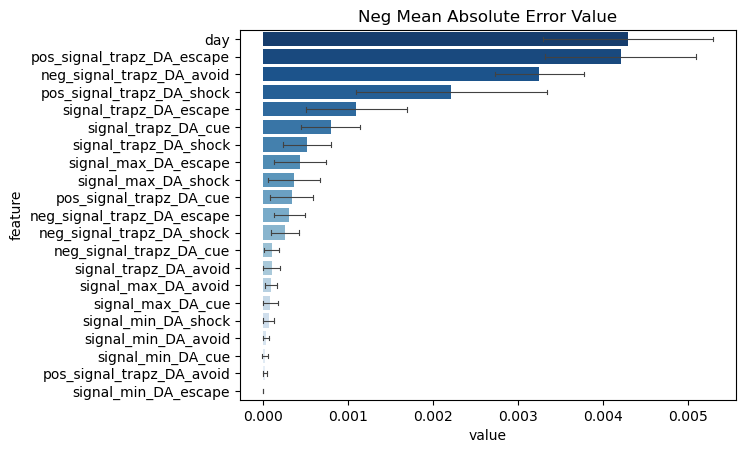

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


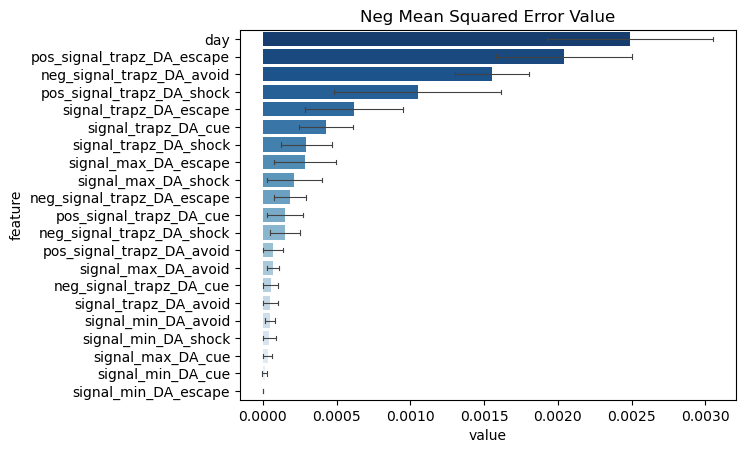

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


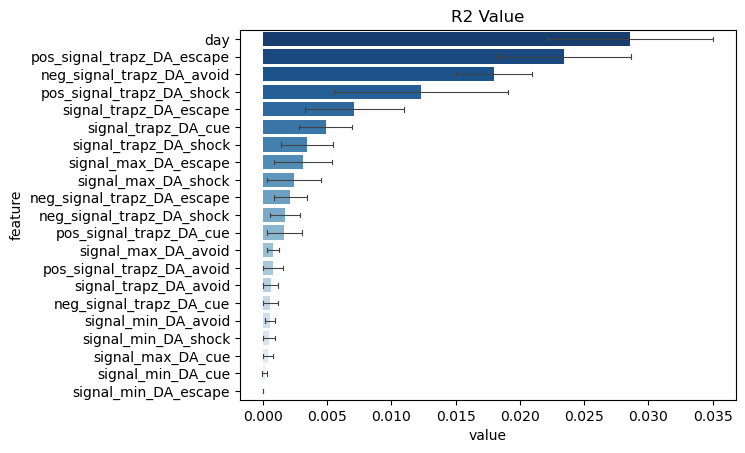

In [140]:
def plot_data(results: pd.DataFrame, query: str):
    feature_order=results.query('scorer==@query').groupby('feature').mean().sort_values(by='value', ascending=False).index
    sns.barplot(data=results.query('scorer==@query'),
                y='feature',
                x='value', 
                orient='h',
                errorbar='se',
                capsize=.25,
                errwidth=0.8,
                order=feature_order, 
                palette='Blues_r')
    plt.title(f'{query.title().replace("_", " ")}')
    
def plot_all_data(results: pd.DataFrame):
    for query in results.scorer.unique():
        plot_data(results, query)
        plt.show()
        

plot_all_data(final_results)

